In [33]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [18]:
train_data = pd.read_csv(r"D:\MachineLearning\NLP\pjt\train.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
val_data = pd.read_csv(r"D:\MachineLearning\NLP\pjt\validation.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
test_data = pd.read_csv(r"D:\MachineLearning\NLP\pjt\test.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)

# Drop ID columns and combine text and labels for processing
train_data.drop('id', axis=1, inplace=True)
val_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [19]:
train_data.head()

,text,labels
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive"
1,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive"
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile


In [20]:
# Preprocessing function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)  # Remove URLs and mentions
    text = text.replace("\n", " ")  # Remove new lines
    tokens = list(re.findall(r'[\u0900-\u097F]+', text))  # Tokenization
    custom_stopwords = ["के", "की", "है", "और", "से", "को", "में", "पर", "के लिए", "यह", "|"]
    cleaned_tokens = [word for word in tokens if word not in custom_stopwords]
    cleaned_text = " ".join(cleaned_tokens)  # Join tokens back into a string
    cleaned_text = re.sub(r"[^\u0900-\u097F\s]+", "", cleaned_text)  # Remove non-Devanagari characters
    return cleaned_text.strip()

# Apply preprocessing
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
val_data['cleaned_text'] = val_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

In [22]:
# Map multi-labels to single labels
label_mapping = {
    "defamation": "defamation",
    "hate": "hate",
    "offensive": "offensive",
    "fake": "fake",
    "non-hostile": "non-hostile"
}
train_data['labels'] = train_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
val_data['labels'] = val_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
test_data['labels'] = test_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))

In [23]:
# Label Encoding
label_encoder = LabelEncoder()
train_data['labels'] = label_encoder.fit_transform(train_data['labels'])
val_data['labels'] = label_encoder.transform(val_data['labels'])
test_data['labels'] = label_encoder.transform(test_data['labels'])

In [24]:
# Tokenization and Padding
max_words = 10000  # Number of words to consider as features
max_len = 100  # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['cleaned_text'])
X_train_seq = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_val_seq = tokenizer.texts_to_sequences(val_data['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['cleaned_text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Targets
y_train = train_data['labels']
y_val = val_data['labels']
y_test = test_data['labels']

In [34]:
# CNN-LSTM Model
# def build_cnn_lstm_model(input_shape, num_classes):
#     input_layer = Input(shape=input_shape)
    
#     # CNN layers
#     x = Embedding(input_dim=max_words, output_dim=128, input_length=input_shape[0])(input_layer)
#     x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=4)(x)
    
#     # LSTM layer
#     x = LSTM(128)(x)
    
#     # Dense output layer
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     output = Dense(num_classes, activation='softmax')(x)
    
#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     return model

def build_cnn_lstm_model(input_shape, num_classes, max_words=10000):
    model = Sequential()
    
    # Embedding layer with increased dimensions
    model.add(Embedding(input_dim=max_words, output_dim=256, input_length=input_shape[0]))
    
    # Stacked CNN layers with Batch Normalization
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256)))
    
    # Dense and Dropout layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Increased dropout to prevent overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile with modified learning rate
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [35]:
num_classes = len(np.unique(y_train))
num_classes

5

In [48]:
# Build and train CNN-LSTM model
input_shape = (max_len,)
num_classes = len(np.unique(y_train))
cnn_lstm_model = build_cnn_lstm_model(input_shape, num_classes)
cnn_lstm_model.summary()

# Fit the model
history=cnn_lstm_model.fit(X_train_pad, y_train, epochs=30, batch_size=64, validation_data=(X_val_pad, y_val))

# Get the feature representations from the CNN-LSTM model
cnn_lstm_features_train = cnn_lstm_model.predict(X_train_pad)
cnn_lstm_features_val = cnn_lstm_model.predict(X_val_pad)
cnn_lstm_features_test = cnn_lstm_model.predict(X_test_pad)

# Train Random Forest classifier on CNN-LSTM features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(cnn_lstm_features_train, y_train)

# Predict on validation and test sets
val_predictions = rf_classifier.predict(cnn_lstm_features_val)
test_predictions = rf_classifier.predict(cnn_lstm_features_test)

C:\Users\Vidul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.4906 - loss: 1.3574 - val_accuracy: 0.5438 - val_loss: 1.3723
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.6201 - loss: 0.9229 - val_accuracy: 0.6104 - val_loss: 1.1921
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7026 - loss: 0.6966 - val_accuracy: 0.4760 - val_loss: 1.2043
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.7760 - loss: 0.5488 - val_accuracy: 0.6289 - val_loss: 0.9163
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.7958 - loss: 0.4469 - val_accuracy: 0.5943 - val_loss: 1.0805
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.8373 - loss: 0.3588 - val_accuracy: 0.6313 - val_loss: 1.1357
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.8638 - loss: 0.2717 - val_accuracy: 0.6449 - val_loss: 1.2008
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8991 - loss: 0.2318 - val_accu

In [49]:
# Evaluate the Random Forest model
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Validation Accuracy: {val_accuracy}")


Validation Accuracy: 0.6362515413070283


In [50]:
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.647912885662432


In [51]:
# Prediction function for new comments
def predict_comment(comment):
    cleaned_comment = clean_text(comment)
    seq = tokenizer.texts_to_sequences([cleaned_comment])
    padded = pad_sequences(seq, maxlen=max_len)
    
    # Get features from CNN-LSTM model
    cnn_lstm_features = cnn_lstm_model.predict(padded)
    
    # Predict with Random Forest classifier
    pred_rf = rf_classifier.predict(cnn_lstm_features)
    
    # Convert predicted label back to original class label
    predicted_label = label_encoder.inverse_transform(pred_rf)[0]
    
    return predicted_label

In [52]:
# Example usage
new_comment = "साले कुत्ते तू हरामी है"
predicted_label = predict_comment(new_comment)
print(f"The predicted label for the comment is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
The predicted label for the comment is: offensive


In [53]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


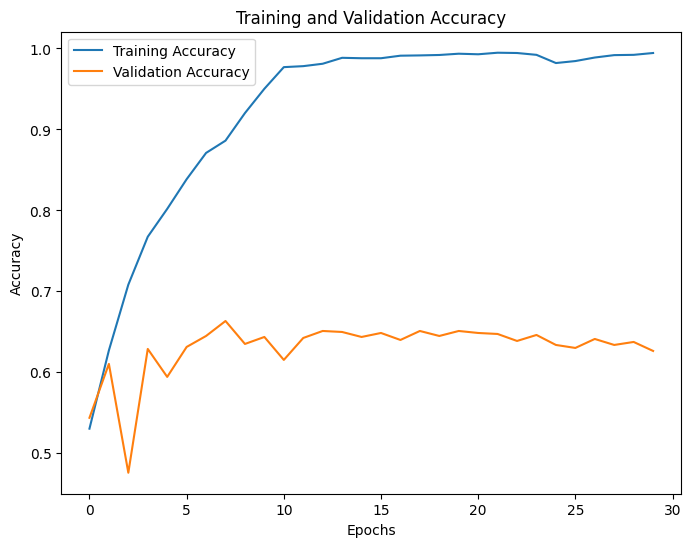

In [54]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

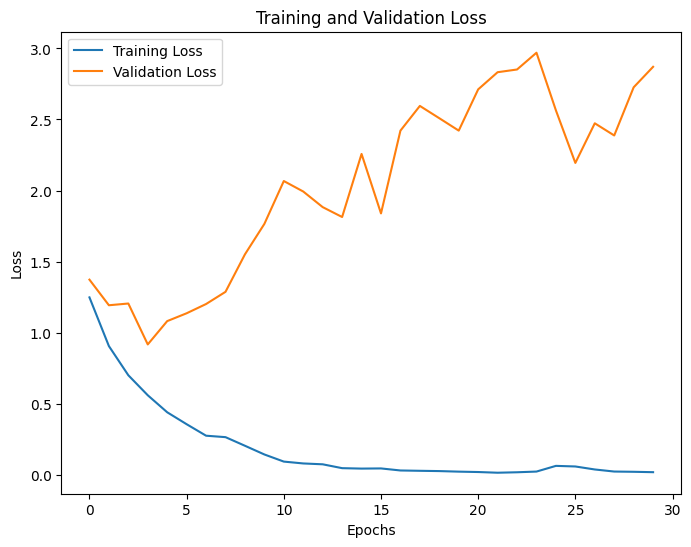

In [55]:
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

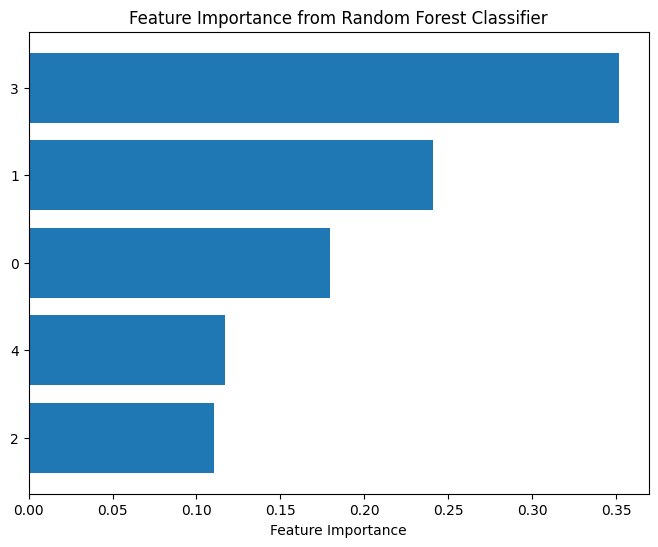

In [56]:
# Feature importance plot
feature_importances = rf_classifier.feature_importances_

# Sort the feature importances
indices = feature_importances.argsort()

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_importances)), feature_importances[indices], align='center')
plt.yticks(range(len(feature_importances)), indices)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()